# Projekt Eksploracji Danych Youtube Trending

## Import bibliotek

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # To plot dates on histograms' axis
import itertools
from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [41]:
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')

## Wczytanie danych

In [42]:
data_gb = pd.read_csv("./youtube_data/GB_videos_5p.csv", sep=";")
data_us = pd.read_csv("./youtube_data/US_videos_5p.csv", sep=";")
data = pd.concat([data_gb, data_us])

In [43]:
data.shape

(79816, 16)

Łącznie, dane z obu plików zawierają 79816 wierszy, z których każdy opisany jest za pomocą następujących atrybutów:

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79816 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  79816 non-null object
trending_date             79816 non-null object
title                     79816 non-null object
channel_title             79816 non-null object
category_id               3930 non-null float64
publish_time              79816 non-null object
tags                      79816 non-null object
views                     79816 non-null int64
likes                     79816 non-null int64
dislikes                  79816 non-null int64
comment_count             79816 non-null int64
thumbnail_link            79816 non-null object
comments_disabled         79816 non-null bool
ratings_disabled          79816 non-null bool
video_error_or_removed    79816 non-null bool
description               78634 non-null object
dtypes: bool(3), float64(1), int64(4), object(8)
memory usage: 8.8+ MB


Przykładowe dane:

In [45]:
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,NaN,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,NaN,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...


## Analiza atrybutów

### video_id

In [46]:
data.video_id.value_counts()

#NAZWA?        725
8h--kFui1JA     65
vjSohj-Iclc     62
VYOjWnS4cMY     61
l884wKofd54     60
zxwfDlhJIpw     59
UUkn-enk2RU     59
BspHjvU11y4     59
5GHXEGz3PJg     59
CX11yw6YL1w     57
vjI4Alon-3Q     56
oWw1BcFhk-k     56
tJfDBSWYqU8     56
u_C4onVrr8U     55
mdWcaWBxxcY     55
ffxKSjUwKdU     55
KUUjtUP2CrE     55
i5qOzqD9Rms     55
6SuMbFuKDf8     54
pFc6I0rgmgY     54
rxmtHVSVjdo     54
iWZmdoY1aTE     53
T4FAg5A4wQk     53
M4ZoCHID9GI     52
OAGfx7eB3gA     52
DdLYSziSXII     52
tjA7nAHOAww     52
pcJo0tIWybY     51
NukmFF__G-g     51
Wpm07-BGJnE     51
              ... 
eYf1IKFNHgM      1
uzK1OmxS4CE      1
aydY1eiGjgs      1
qaSOyhK3gTM      1
bhoFXkVy8JA      1
uT3wso5Zp7k      1
N-3NfWJHNhg      1
CefAPPIkB8E      1
G8gJ4RTBxcg      1
SCnVbXlC1Ds      1
D3uvvA7dyoI      1
PitmObjGur4      1
djlaHJCXT4o      1
7m630xvAJtA      1
ZzZ-BsiSamk      1
9L4-DV1nVek      1
ufOnBRXy3Pc      1
uO_8d1t5Xh4      1
tCnbAAgfxH8      1
egXr0PU-kCY      1
Zvg6b6q1s-Y      1
BWhqHJtvbPo 

Wśród danych 725 razy występuje `#NAZWA?`. Jest to błąd danych, który należy albo naprawić, albo usunąć wiersze z występującym błędem. Po przyjrzeniu się danym, można zauważyć, że dla każdego innego wiersza, wartość pola `video_id` występuje również w atrybucie `thumbnail_link` jako część linku do miniaturki filmu. Aby nie tracić danych, posłużono się tym atrybutem, wycinając ze ścieżki odpowiedni człon i zastąpiono nim błędne pole `video_id`.

In [47]:
def get_id(v_id, link):
    if v_id == "#NAZWA?":
        tokens = link.split('/')
        return tokens[-2]
    else: return v_id

In [48]:
data['video_id'] = data.apply(lambda row : get_id(row.video_id, row.thumbnail_link), axis = 1) 

In [49]:
data.to_csv("./youtube_data/videos_5p.csv", sep=";") # zapisujemy poprawione dane w celu późniejszego wykorzystania do komunikacji poprzez YT API

In [50]:
data.video_id.value_counts()

8h--kFui1JA    65
vjSohj-Iclc    62
VYOjWnS4cMY    61
l884wKofd54    60
BspHjvU11y4    59
5GHXEGz3PJg    59
UUkn-enk2RU    59
zxwfDlhJIpw    59
CX11yw6YL1w    57
vjI4Alon-3Q    56
oWw1BcFhk-k    56
tJfDBSWYqU8    56
ffxKSjUwKdU    55
KUUjtUP2CrE    55
i5qOzqD9Rms    55
mdWcaWBxxcY    55
u_C4onVrr8U    55
pFc6I0rgmgY    54
6SuMbFuKDf8    54
rxmtHVSVjdo    54
T4FAg5A4wQk    53
iWZmdoY1aTE    53
M4ZoCHID9GI    52
DdLYSziSXII    52
OAGfx7eB3gA    52
tjA7nAHOAww    52
kton-qrKNLc    51
Wpm07-BGJnE    51
pcJo0tIWybY    51
NukmFF__G-g    51
               ..
ydRw4zylmbw     1
5vQcI9phkyk     1
w9JQf4Lw46g     1
VRHhT9f6e0k     1
1cUUfMeOijg     1
RQpGCAkpEtY     1
rXqh6AcIb-c     1
Bu2Djx2ejlA     1
eOcJ27xT99w     1
SsmgtO1zAhg     1
Q6Usd3_fbq8     1
j3IYFeVwf5I     1
s1yurGsRM_s     1
QzfnWcHhdyQ     1
IXJhN4cOVM0     1
Lr8VpJ2GX2E     1
3VbHg5fqBYw     1
BEweWXa5Twk     1
I-xZz2OabW0     1
DJMyDoYkioY     1
SC8Eg0odTfY     1
P2z7Jwu5OfQ     1
JlcJaCS4BPM     1
rovAxg5A48Q     1
48SbgzxKW-

Atrybut `video_id` jest identyfikatorem filmu w serwisie YouTube. Wśród wszystkich wpisów występuje tylko 8606 unikalnych identyfikatorów, co oznacza, że większość filmów utrzymywała się na liście Trending przez dłuższy czas.

### trending_date

In [51]:
data.trending_date = pd.to_datetime(data.trending_date, format="%y.%d.%m")

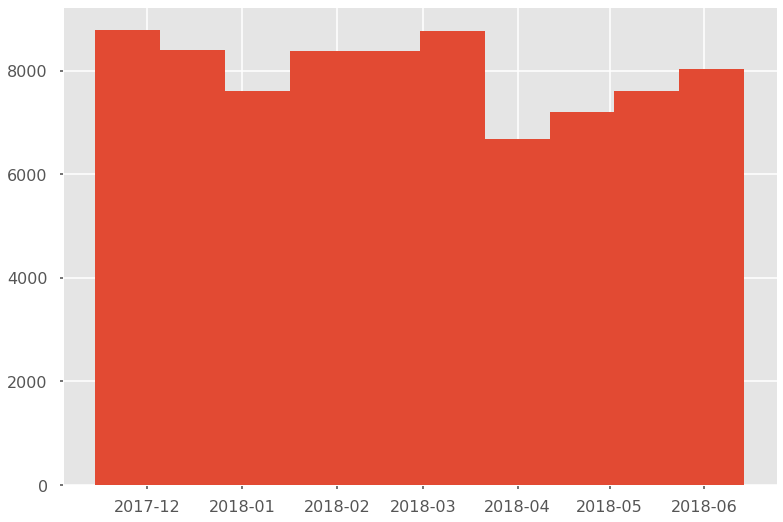

In [52]:
data.trending_date.hist()

Dane pochodzą z okresu od listopada 2017 roku do czerwca 2018 roku i są rozłożone równomiernie.

### title

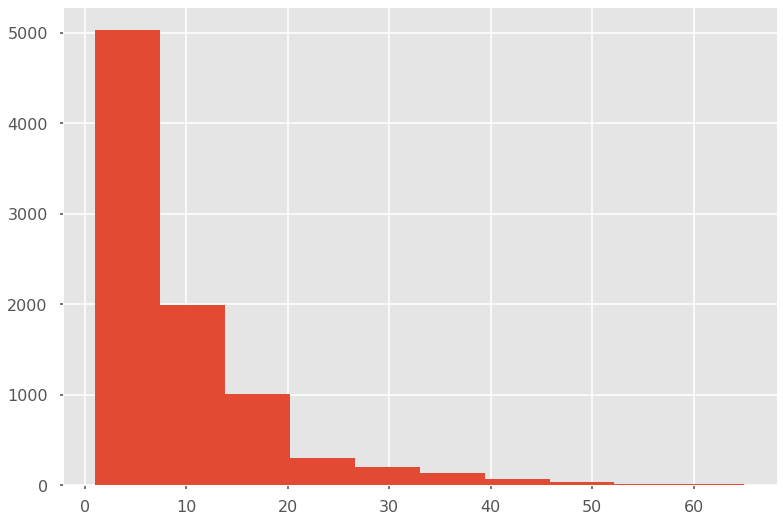

In [53]:
data.title.value_counts()
data.title.value_counts().hist()

Większość filmów była na liście Trending raz lub kilka razy, natomiast zdarzały się również takie, które utrzymywały się przez długi okres czasu.

### Channel title

The Tonight Show Starring Jimmy Fallon    404
TheEllenShow                              400
Jimmy Kimmel Live                         393
Saturday Night Live                       380
Netflix                                   380
Late Night with Seth Meyers               377
The Late Show with Stephen Colbert        376
The Late Late Show with James Corden      365
WWE                                       361
ESPN                                      334
Warner Bros. Pictures                     318
CNN                                       305
WIRED                                     305
Screen Junkies                            297
Marvel Entertainment                      273
20th Century Fox                          273
Breakfast Club Power 105.1 FM             251
Vogue                                     251
SMTOWN                                    250
Vox                                       248
Star Wars                                 247
BBC Radio 1                       

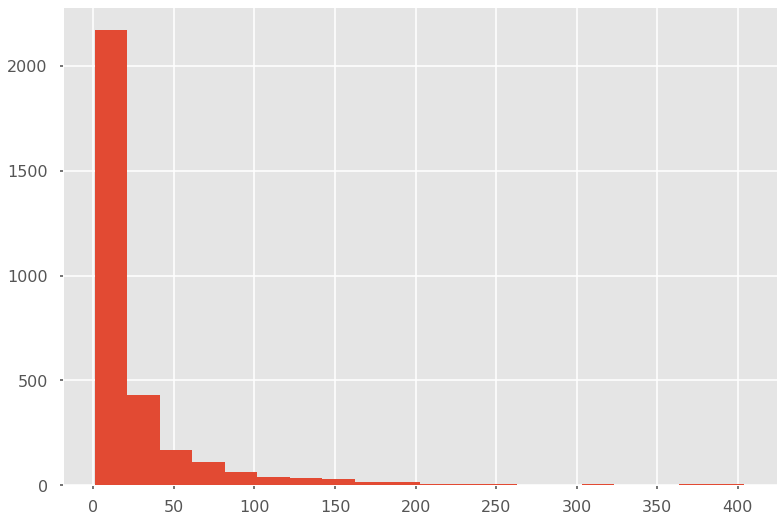

In [54]:
data.channel_title.value_counts().hist(bins=20)
data.channel_title.value_counts()

Niektóre kanały występują w danych znacznie częściej niż inne. Jest to spowodowane tym, że są to kanały znane globalnie, mające dużą ilość subskrybentów. Łatwiej im trafić do większej publiczności i zdobyć wysoką popularność filmów.

### category_id

In [55]:
data.category_id.value_counts(dropna=False)
data.category_id.isnull().sum()*100/len(data)

95.07617520296682

Nazwa kategorii jest pusta dla 95% przypadków. Jak wiemy z opisu ćwiczenia, uzupełnienie jej będzie jednym z zadań, dlatego na tym etapie pozostaje niezmieniona.

### publish_time

In [56]:
data.publish_time.head()
data.publish_time = pd.to_datetime(data.trending_date)

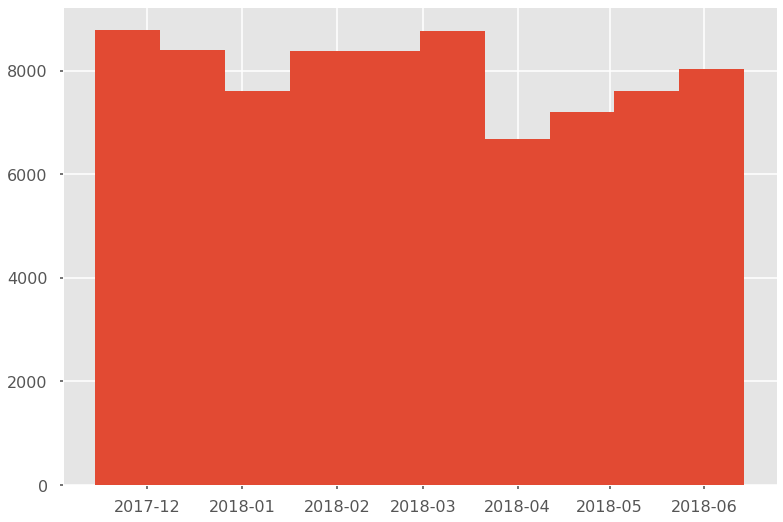

In [57]:
data.publish_time.hist()

### Tags

In [58]:
data.tags.head()

0    christmas|"john lewis christmas"|"john lewis"|...
1    SNL|"Saturday Night Live"|"SNL Season 43"|"Epi...
2    Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...
3    Salford City FC|"Salford City"|"Salford"|"Clas...
4                                               [none]
Name: tags, dtype: object

In [59]:
data.tags.values[0]

'christmas|"john lewis christmas"|"john lewis"|"christmas ad"|"mozthemonster"|"christmas 2017"|"christmas ad 2017"|"john lewis christmas advert"|"moz"'

In [60]:
data.tags.values[0].replace('"',"").split('|')

['christmas',
 'john lewis christmas',
 'john lewis',
 'christmas ad',
 'mozthemonster',
 'christmas 2017',
 'christmas ad 2017',
 'john lewis christmas advert',
 'moz']

In [127]:
def prepare_tags(tags):
    return tags.replace('"', '').split('|') if tags != '[none]' else None

data['tags_split'] = data.tags.apply(prepare_tags)

In [128]:
all_tags = [tags for tags in data.split_tags if tags != None]
all_tags = list(itertools.chain.from_iterable(all_tags))
tags100 = {a: b for a, b in Counter(all_tags).most_common(100)}

In [129]:
wordcloud = WordCloud(background_color='white',
                      max_words=50, 
                      max_font_size=40,
                      random_state=42).generate_from_frequencies(tags100)

Text(0.5, 1.0, 'Most used tags')

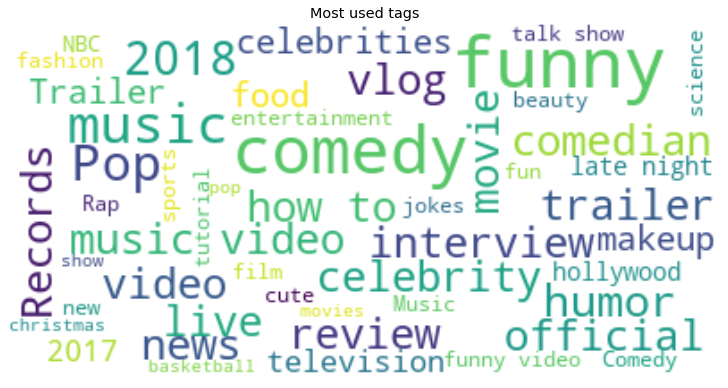

In [130]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.grid(b=None)
plt.axis("off")
plt.title("Most used tags")

Na powyższej grafice przedstawiono najczęściej występujące tagi. Większość z nich związana jest z rozrywką i spędzaniem czasu wolnego.

### Views

In [65]:
data.views.describe()

count    7.981600e+04
mean     4.089589e+06
std      1.439442e+07
min      5.490000e+02
25%      2.462062e+05
50%      7.952275e+05
75%      2.533302e+06
max      4.245389e+08
Name: views, dtype: float64

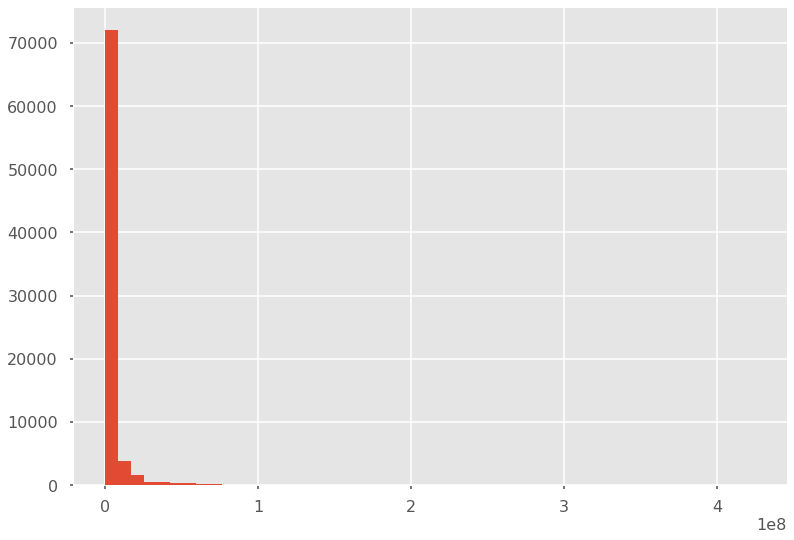

In [66]:
data.views.hist(bins=50)

### Likes

In [67]:
data.likes.describe()

count    7.981600e+04
mean     1.036131e+05
std      2.958002e+05
min      0.000000e+00
25%      5.637750e+03
50%      2.090300e+04
75%      7.816350e+04
max      5.613827e+06
Name: likes, dtype: float64

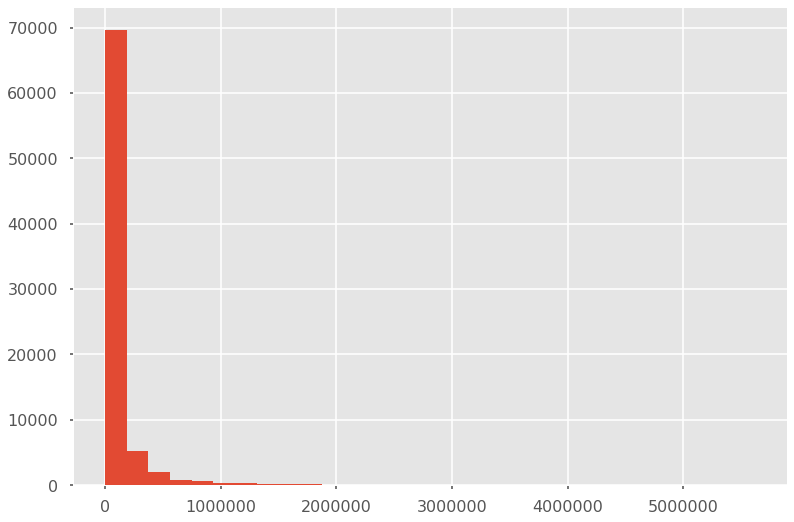

In [68]:
data.likes.hist(bins=30)

### Dislikes

In [69]:
data.dislikes.describe()

count    7.981600e+04
mean     5.612412e+03
std      4.125681e+04
min      0.000000e+00
25%      2.010000e+02
50%      7.110000e+02
75%      2.526000e+03
max      1.944971e+06
Name: dislikes, dtype: float64

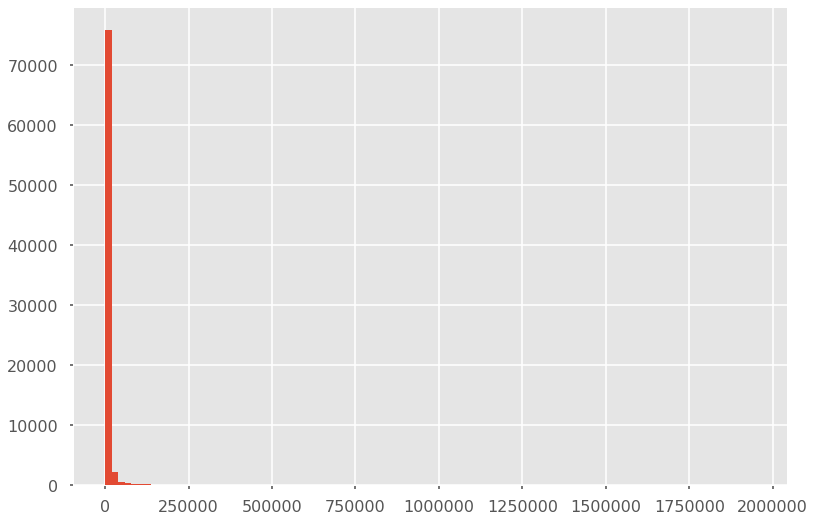

In [70]:
data.dislikes.hist(bins=100)

### Comment count

In [71]:
data.comment_count.describe()

count    7.981600e+04
mean     1.070894e+04
std      4.444967e+04
min      0.000000e+00
25%      6.420000e+02
50%      2.099000e+03
75%      7.215000e+03
max      1.626501e+06
Name: comment_count, dtype: float64

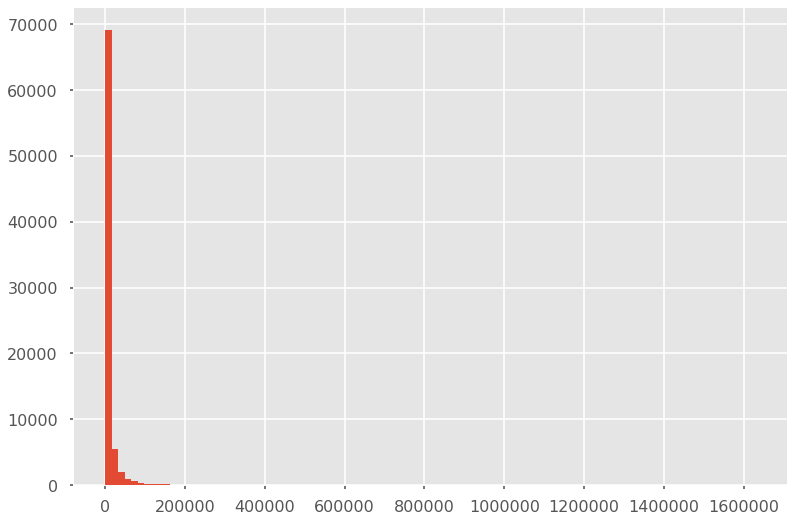

In [72]:
data.comment_count.hist(bins=100)

Liczba wyświetleń, poozytywnych i negatywnych reakcji a także liczba komentarzy mają rozkład prawoskośny - w danych występuje mała liczba filmów o rekordowej oglądalności, wzbudzających bardzo dużo pozytywnych i negatywnych reakcji i komentarzy. Większość filmów jest do siebie zbliżona z globalnego punktu widzenia.

### Thumbnail_link

In [73]:
data.thumbnail_link.head()

0    https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg
1    https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg
2    https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg
3    https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg
4    https://i.ytimg.com/vi/rHwDegptbI4/default.jpg
Name: thumbnail_link, dtype: object

Wszystkie linki mają podobną strukturę: różnią się jedynie członem stanowiącym identyfikator filmu.

### comments_disabled

In [74]:
data.comments_disabled.value_counts()

False    78501
True      1315
Name: comments_disabled, dtype: int64

Filmy z wyłączoną możliwością komentowania stanowią jedynie 1,65% całego zbioru danych. W dalszej części projektu ciekawym zagadnieniem może okazać się analiza tych filmów - jakie były prawdopodobne powody wyłączenia komentarzy oraz jednoczesna wysoka popularność - może były to komunikaty rządowe, kontrowersyjne treści, a może jeszcze inne? 

### Rating disabled

In [75]:
data.ratings_disabled.value_counts()

False    79376
True       440
Name: ratings_disabled, dtype: int64

Filmy z wyłączoną możliwością oceniania stanowią 0,55% całego zbioru danych. Jak wyżej, analiza powodów takiej decyzji może być interesującym zagadnieniem.

### video_error_or_removed 

In [76]:
data.video_error_or_removed.value_counts()

False    79724
True        92
Name: video_error_or_removed, dtype: int64

Filmy usunięte lub powodujące błędy stanowią 0,12% całego zbioru danych. Być może niektóre z nich zdobyły popularność ze względu wysokiej kontrowersyjności i zostały z tego samego powodu usunięte? Może łamały prawa autorskie? Przyjrzymy się im w kolejnym etapie analizy.

**Can we remove those ones? --- jak będzie nam się chciało to ja bym z ciekwości poszukała co to są za filmy i dlaczego mogły zostać usunięte ---> Być może wnioskiem z całej analizy będzie "Wrzuć na Jutuba film, który będzie obrażał wszystkich, byc może uda ci się być w trending zanim ktoś w YT się ogarnie" XD Zrobiłabym sprawdzenie korelacji z liczbą dislikes.**

### description

In [77]:
data.columns = data.columns.str.replace('description ', 'description')

In [78]:
data.description.values[0]

"Click here to continue the story and make your own monster:\\nhttp://bit.ly/2mboXgj\\n\\nJoe befriends a noisy Monster under his bed but the two have so much fun together that he can't get to sleep, leaving him tired by day. For Christmas Joe receives a gift to help him finally get a good night’s sleep.\\n\\nShop the ad\\nhttp://bit.ly/2hg04Lc\\n\\nThe music is Golden Slumbers performed by elbow, the original song was by The Beatles. \\nFind the track:\\nhttps://Elbow.lnk.to/GoldenSlumbersXS\\n\\nSubscribe to this channel for regular video updates\\nhttp://bit.ly/2eU8MvW\\n\\nIf you want to hear more from John Lewis:\\n\\nLike John Lewis on Facebook\\nhttp://www.facebook.com/johnlewisretail\\n\\nFollow John Lewis on Twitter\\nhttp://twitter.com/johnlewisretail\\n\\nFollow John Lewis on Instagram\\nhttp://instagram.com/johnlewisretail"

## Wytworzenie atrybutów do predykcji

Dostępne atrybuty są mniej lub bardziej informatywne dla postawionego problemu. Na przykład można zastanowić się, czy liczba pozytywnych reakcji sprzyja wyższej oglądalności, jednak nie jest to czynnik, który autor filmu ma pod kontrolą. Niektóre z artybutów można poddać dodatkowym operacjom mającym na celu ekstrakcję cech, które będą przydatne w procesie odkrywania wiedzy. Do takich atrybutów należą na pewno: `title`, `tags`, `description`. Atrybuty takie jak: `comments_disabled`, `ratings_disabled`, `comment_count`, `video_error_or_removed`, `dislikes`, `publish_time` mogą częściowo wchodzić w korelacje z innymi atrybutami (np. można spodziewać się, że w okresie świątecznym w tagach będzie przeważało słowo "christmas", flaga `video_error_or_removed` może być w zależności z liczbą negatywnych reakcji itp.). Atrybutami, których nie będziemy analizować w tej części są: `video_id` - ze względu na to, że jest to unikalny identyfikator filmu, `views` - niemożność bezpośredniego wpływu, `category_id` - brak danych z wiadomych przyczyn.

Odnośnie dalszych działań to bym to widziała tak:
- Dla każdego z {title, tags, description}:
   
    - tokenizacja
    - usunięcie stopwords
    - (lematyzacja/stemming)
    - wytworzenie reprezentacji word2vec, tfidf, embeddings (nwm czy wszystkie, może tylko niektóre/jeden z nich albo inne)
    - ? może wytworzenie jakiegoś/jakichś binarnych atrybutów mówiących o tym, czy posiada słowa, które w danym czasie były najbardziej "na czasie" - tzn. na przykład w lipcu mamy, że najczęściej pojawiają się "science, independence, cat" i atrybut miałby True, jeśli dla tego filmu też występuję jedno z nich np. "science"  **Bardzo podoba mi się pomysł**
    - procentowa zawartość capital letters
    - obecność znaków typu emotikony, wykrzykniki, znaki zapytania itp.
    - długość całego tekstu
    
    
- sprawdzenie prawdopodobnych korelacji, o których pisałam wyżej
- Równolegle dobrze by było ogarnąć YouTube API i zacząć ściągać dane potrzebne do punktu 5

Propozycje atrybutów tekstowych:,
 * Czy występuje link / ilość linków,
 * Czy opis zawiera tagi / ilość tagów zawartych w opisie,
 * Ilość tagów,    
 * Czy zawarty jest link do FB / Instagrama / SnapChata / Twittera... (lub czy w ogóle do jakichś mediów społecznościowych),
 * Długość opisu,
 * NLP - Proponuję użyć Tf-Idf by mieć punkt wyjścia i jednej DLowej metody - ELMO lub BERT (ja mam doświadczenie z ELMO),
 
Atrybuty pozatekstowe:
  * Czy opublikowane w weekend,
  * Godzina publikacji (kodowanie atrybutu - ciekawy temat),
  * Czy jest muzyką? (pytanie jak sprawdzić?),
  * Czy komentarze wyłączone,
  * Czy rating wyłączony

In [132]:
def length(wordlist):
    if wordlist is None: return 0
    else: return len(wordlist)
def onlyalpha(string):
    return word_tokenize(''.join([char for char in string if char.isalpha() or char.isspace()]))
def count_capitals(alphalist):
    string = ''.join(alphalist)
    if len(string) == 0:
        return 0
    else: return len([char for char in string if char.isupper()])/ len(string)

In [133]:
data['title_split'] = data.title.apply(word_tokenize)
data['title_alpha'] = data.title.apply(onlyalpha)
data['title_num_words'] = data.title_alpha.apply(length)
data['title_capital'] = data.title_alpha.apply(count_capitals)
data['title_exc_count'] = data.apply(lambda row: row['title'].count('!'), axis=1)
data['title_que_count'] = data.apply(lambda row: row['title'].count('?'), axis=1)

In [134]:
data[['video_id','title_split', 'title_alpha', 'title_num_words', 'title_capital', 'title_exc_count', 'title_que_count']]

,video_id,title_split,title_alpha,title_num_words,title_capital,title_exc_count,title_que_count
0,Jw1Y-zhQURU,"[John, Lewis, Christmas, Ad, 2017, -, #, MozTh...","[John, Lewis, Christmas, Ad, MozTheMonster]",5,0.212121,0,0
1,3s1rvMFUweQ,"[Taylor, Swift, :, …Ready, for, It, ?, (, Live...","[Taylor, Swift, Ready, for, It, Live, SNL]",7,0.285714,0,1
2,n1WpP7iowLc,"[Eminem, -, Walk, On, Water, (, Audio, ), ft.,...","[Eminem, Walk, On, Water, Audio, ft, Beyoncé]",7,0.193548,0,0
3,PUTEiSjKwJU,"[Goals, from, Salford, City, vs, Class, of, 92...","[Goals, from, Salford, City, vs, Class, of, an...",13,0.133333,1,0
4,rHwDegptbI4,"[Dashcam, captures, truck, 's, near, miss, wit...","[Dashcam, captures, trucks, near, miss, with, ...",9,0.043478,0,0
5,AumaWl0TNBo,"[How, My, Relationship, Started, !]","[How, My, Relationship, Started]",4,0.166667,1,0
6,2Vv-BfVoq4g,"[Ed, Sheeran, -, Perfect, (, Official, Music, ...","[Ed, Sheeran, Perfect, Official, Music, Video]",6,0.176471,0,0
7,-N5eucPMTTc,"[CHRISTMAS, HAS, GONE, TO, MY, HEAD]","[CHRISTMAS, HAS, GONE, TO, MY, HEAD]",6,1.000000,0,0
8,LMCuKltaY3M,"[Elbow, -, Golden, Slumbers, (, John, Lewis, A...","[Elbow, Golden, Slumbers, John, Lewis, Advert]",6,0.176471,0,0
9,9t9u_yPEidY,"[Jennifer, Lopez, -, Amor, ,, Amor, ,, Amor, (...","[Jennifer, Lopez, Amor, Amor, Amor, Official, ...",9,0.177778,0,0


In [135]:
data['tags_count'] = data.tags_split.apply(length)

In [139]:
data[['video_id','tags','tags_split', 'tags_count']].head(8)

,video_id,tags,tags_split,tags_count
0,Jw1Y-zhQURU,"christmas|""john lewis christmas""|""john lewis""|...","[christmas, john lewis christmas, john lewis, ...",9
1,3s1rvMFUweQ,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...","[SNL, Saturday Night Live, SNL Season 43, Epis...",36
2,n1WpP7iowLc,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...","[Eminem, Walk, On, Water, Aftermath/Shady/Inte...",6
3,PUTEiSjKwJU,"Salford City FC|""Salford City""|""Salford""|""Clas...","[Salford City FC, Salford City, Salford, Class...",9
4,rHwDegptbI4,[none],None,0
5,AumaWl0TNBo,"pointlessblog|""pointlessblogtv""|""pointlessblog...","[pointlessblog, pointlessblogtv, pointlessblog...",38
6,2Vv-BfVoq4g,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...","[edsheeran, ed sheeran, acoustic, live, cover,...",10
7,-N5eucPMTTc,"zoe sugg|""zoella""|""zoe""|""vlog""|""vlogging""|""vlo...","[zoe sugg, zoella, zoe, vlog, vlogging, vlogs,...",31


In [141]:
data['description']

0        Click here to continue the story and make your...
1        Musical guest Taylor Swift performs …Ready for...
2        Eminem's new track Walk on Water ft. Beyoncé i...
3        Salford drew 4-4 against the Class of 92 and F...
4        Dashcam captures truck's near miss with child ...
5        ► HOW MY RELATIONSHIP STARTED!\n► PB Merch • h...
6        🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
7        CHRISTMAS HAS GONE TO MY HEAD\nPrevious Vlog: ...
8        “Golden Slumbers”, originally by The Beatles, ...
9        Jennifer Lopez ft. Wisin - Amor, Amor, Amor (O...
10       ➢ Join my FREE 7 Steps to Success - http://www...
11       More from Inside Edition: https://www.youtube....
12       Gucci Mane - Curve feat. The Weeknd\n\n Mr. Da...
13       -\n\n\nWebsite - http://www.johnmaclean.co.uk\...
14       Today I show you how to completely dry a shirt...
15       Trust us, there's nowhere else in the universe...
16       You have to watch this! Sam serenades a couple.

In [145]:
def tokenize(column):
    if column is None:
        return []
    else: return word_tokenize(column)

In [ ]:
data['desc_split'] = data.description.apply(tokenize)
data['desc_alpha'] = data.description.apply(onlyalpha)
data['desc_num_words'] = data.desc_alpha.apply(length)
data['desc_capital'] = data.title_alpha.apply(count_capitals)
data['desc_exc_count'] = data.apply(lambda row: row['description'].count('!'), axis=1)
data['desc_que_count'] = data.apply(lambda row: row['description'].count('?'), axis=1)